In [ ]:
import string
import numpy as np
import PIL.Image

from os import listdir
from pickle import dump, load

from numpy import array
from numpy import argmax
from time import time
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from nltk.translate.bleu_score import corpus_bleu
import progressbar
from time import sleep

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
import os
prefix = '/content/gdrive/My Drive/'
customized_path = 'DeepLearning'
sys_path = os.path.join(prefix, customized_path)
sys.path.append(sys_path)
%cd /content/gdrive/MyDrive/DeepLearning
!ls

/content/gdrive/MyDrive/DeepLearning
best_model_c100.h5		ImageCap_Data
best_model_c10.h5		MidTerm
best_resnet_model_c100.h5	model_inceptionv3.png
best_resnet_model_c10.h5	model_inceptionv.png
best_tf_resnet50_model_c100.h5	model.png
best_tf_resnet50_model_c10.h5	MR_CNN_model.h5
c10_resnet20_model.103.h5	MultiresCNN-network.png
cat.png				PaaperPresentation.gslides
cnn-y-network.png		resnet.png
descriptions_test.txt		sample_data
descriptions.txt		saved_models
features_test_Inception.pkl	saved_models_mrc
features_test.pkl		saved_models_mt
features_train_Inception.pkl	VC_CNN_model.h5
features_train.pkl		VGG_CNN_model.h5


In [ ]:
# Funtion to Extract features from each photo in the directory
def extract_features(directory, model_name):

    CNN_models = [VGG16(weights="imagenet"),InceptionV3(weights="imagenet")]
    
    if model_name == "VGG16" :    
      # Loading the model
      model = CNN_models[0]
      input_img_shape = (224,224)
      # For VGG16 Removing the last layer from the loaded model as we require only the features not the classification 
      model.layers.pop()
      model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
      print(model.summary())

    elif model_name == "InceptionV3":
      model = CNN_models[1]
      input_img_shape = (299,299)
      # Create a new model, by removing the last layer (output layer) from the inception v3
      model = Model(model.input, model.layers[-2].output)
      # Summarizing the model 
      print(model.summary())

    else:
      print("Select a model from VGG16 or InceptionV3"+"\n"+"More models to be added")
    # Extracting features from each photo and storing it in a dictionary 
    features = dict()
    bar = progressbar.ProgressBar(maxval=len(listdir(directory)), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for i,name in enumerate(listdir(directory)):

        # Defining the path of the image 
        filename = directory + '/' + name
        
        # Loading an image and converting it into size 224 * 224
        ## Yet to be automated. For now manually change to appropriate input size
        image = load_img(filename, target_size=input_img_shape)
        
        # Converting the image pixels into a numpy array
        image = img_to_array(image)
       # Reshaping data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        
        # Preprocessing the images for the VGG model
        # The preprocess_input function is meant to adequate your image to the format the model requires.
        image = preprocess_input(image)

        # Getting features of an image
        feature = model.predict(image, verbose=0)
        
        # Getting the image name
        image_id = name.split('.')[0]

        # Storing the feature corresponding to the image in the dictionary
        features[image_id] = feature
        bar.update(i+1)
        sleep(0.1)
        #print('>%s' % name)
    bar.finish()
        
        
    return features

In [ ]:
# Loading the file containg all the descriptions into memory

def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')

    # Reading all text and storing it.
    text = file.read()

    # Closing the file
    file.close()
    
    return text

In [ ]:
# Defining the directory we are using
directory_train = 'ImageCap_Data/VizWiz_Data_train1/train1'


## Extracting features from all the images
# Here we also set(by name) the model used for generating image vectors
model_names = ["VGG16","InceptionV3"] 

start = time()
features_train = extract_features(directory_train,model_names[0])
dump(features_train, open('features_train.pkl', 'wb'))
print("Time taken to encode train set in seconds =", time()-start)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
print('Extracted Features using VGG16: ', len(features_train))

Extracted Features using VGG16:  8000


In [ ]:
directory_test = 'ImageCap_Data/VizWiz_Data_val/val/val'
model_names = ["VGG16","InceptionV3"] 
start = time()
features_test = extract_features(directory_test,model_names[0])
print("Time taken to encode test set in seconds =", time()-start)
print('Extracted Features using VGG16: ', len(features_test))
# Dumping the features in a pickle file for further use
dump(features_test, open('features_test.pkl', 'wb'))

96116736/96112376 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

[========================================================================] 100%


Time taken to encode test set in seconds = 4437.802843332291
Extracted Features using VGG16:  7750


In [ ]:
directory_train = 'ImageCap_Data/VizWiz_Data_train1/train1'
model_names = ["VGG16","InceptionV3"] 

start = time()
features_train = extract_features(directory_train,model_names[1])
print("Time taken to encode train set in seconds =", time()-start)
print('Extracted Features using InceptionV3: ', len(features_train))

start = time()
features_test = extract_features(directory_test,model_names[1])
print("Time taken to encode test set in seconds =", time()-start)
dump(features_train, open('features_train_Inception.pkl', 'wb'))

#print('Extracted Features using VGG16: ', len(features))
print('Extracted Features using InceptionV3: ', len(features_train))

# Dumping the features in a pickle file for further use
dump(features_test, open('features_test_Inception.pkl', 'wb'))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

[========================================================================] 100%


Time taken to encode train set in seconds = 5489.989305496216
Extracted Features using InceptionV3:  8000
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_

[========================================================================] 100%


Time taken to encode test set in seconds = 1352.5021405220032
Extracted Features using InceptionV3:  8000


In [ ]:
## Function to map descriptions to images 
def photo_to_description_mapping(descriptions):
    
    # Dictionary to store the mapping of photo identifiers to descriptions
    description_mapping = dict()
    
    # Iterating through each line of the descriptions
    for line in descriptions.split('\n'):
        
        # Splitting the lines by white space
        words = line.split()
        
        # Skipping the lines with length less than 2
        if len(line)<2:
            continue
            
        # The first word is the image_id and the rest are the part of the description of that image
        image_id, image_description = words[0], words[1:]
        
        # Retaining only the name of the image and removing the extension from it
        image_id = image_id.split('.')[0]
        
        # Image_descriptions contains comma separated words of the description, hence, converting it back to string
        image_description = ' '.join(image_description)
                # There are multiple descriptions per image, 
        # hence, corresponding to every image identifier in the dictionary, there is a list of description
        # if the list does not exist then we need to create it
        
        if image_id not in description_mapping:
            description_mapping[image_id] = list()
            
        # Now storing the descriptions in the mapping
        description_mapping[image_id].append(image_description)
    
    return description_mapping

In [ ]:
"""
Function to clean the descriptions in the following ways:

Convert all words to lowercase.
Remove all punctuation.
Remove all words that are one character or less in length (e.g. ‘a’).
Remove all words with numbers in them.

"""

def clean_descriptions(description_mapping):
    
    # Preapring a translation table for removing all the punctuation
    table = str.maketrans('','', string.punctuation)
    
    # Traversing through the mapping we created
    for key, descriptions in description_mapping.items():
        for i in range(len(descriptions)):
            description = descriptions[i]
            description = description.split()
            
            # Converting all the words to lower case
            description = [word.lower() for word in description]
            
            # Removing the punctuation using the translation table we made
            description = [word.translate(table) for word in description]
            
            # Removing the words with length =1
            description = [word for word in description if len(word)>1]
            
            # Removing all words with number in them
            description = [word for word in description if word.isalpha()]
            
            # Converting the description back to string and overwriting in the descriptions list
            descriptions[i] = ' '.join(description)

In [ ]:
def to_vocabulary(descriptions):
    
    # Build a list of all description strings
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    
    return all_desc

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [ ]:
filename = 'ImageCap_Data/VizWiz_Data_train1/annotations2.txt'

# Loading descriptions
doc = load_doc(filename)

# Parsing descriptions
descriptions = photo_to_description_mapping(doc)
print('Loaded: %d ' % len(descriptions))

# Cleaning the descriptions
clean_descriptions(descriptions)

# Summarizing the vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# Saving to the file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8000 
Vocabulary Size: 10929


In [ ]:
# Function for loading a file into memory and returning text from it
def load_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Function for loading a pre-defined list of photo identifiers
def load_photo_identifiers(filename):
    
    # Loading the file containing the list of photo identifier
    file = load_file(filename)
    
    # Creating a list for storing the identifiers
    photos = list()
    
    # Traversing the file one line at a time
    for line in file.split('\n'):
        if len(line) < 1:
            continue
        
        # Image name contains the extension as well but we need just the name
        identifier = line.split('.')[0]
        
        # Adding it to the list of photos
        photos.append(identifier)
    # Returning the set of photos created
    return set(photos)


# loading the cleaned descriptions that we created earlier
# we will only be loading the descriptions of the images that we will use for training
# hence we need to pass the set of train photos that the above function will be returning

def load_clean_descriptions(filename, photos):
    
    #loading the cleaned description file
    file = load_file(filename)
    
    #creating a dictionary of descripitions for storing the photo to description mapping of train images
    descriptions = dict()
    
    #traversing the file line by line
    for line in file.split('\n'):
        # splitting the line at white spaces
        words = line.split()
        
        # the first word will be the image name and the rest will be the description of that particular image
        image_id, image_description = words[0], words[1:]
        
        # we want to load only those description which corresponds to the set of photos we provided as argument
        if image_id in photos:
            #creating list of description if needed
            if image_id not in descriptions:
                descriptions[image_id] = list()
            #the model we will develop will generate a caption given a photo, 
            #and the caption will be generated one word at a time. 
            #The sequence of previously generated words will be provided as input. 
            #Therefore, we will need a ‘first word’ to kick-off the generation process 
            #and a ‘last word‘ to signal the end of the caption.
            #we will use 'startseq' and 'endseq' for this purpose
            #also we have to convert image description back to string
            
            desc = 'startseq ' + ' '.join(image_description) + ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions

# function to load the photo features created using the VGG16 model
def load_photo_features(filename, photos):
    
    #this will load the entire features
    all_features = load(open(filename, 'rb'))
    
    #we are interested in loading the features of the required photos only
    features = {k: all_features[k] for k in photos}
    
    return features

In [ ]:
filename = 'ImageCap_Data/VizWiz_Data_train1/annotations2.txt'
train = load_photo_identifiers(filename)
print('Dataset: ',len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))

train_features = load_photo_features('features_train.pkl', train)
print('Photos: train=', len(train_features))


Dataset:  8000
Descriptions: train= 8000
Photos: train= 8000


In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Given the descriptions, fit a tokenizer

# TOKENIZER CLASS:
# This class allows to vectorize a text corpus, 
# by turning each text into either a sequence of integers 
# (each integer being the index of a token in a dictionary) 
# or, into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  10932


In [ ]:
#calculated the length of description with most words
def max_lengthTEMP(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [ ]:
#the below function loop forever with a while loop and within this, 
#loop over each image in the image directory. 
#For each image filename, we can load the image and 
#create all of the input-output sequence pairs from the image’s description.

#data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            photo = photos[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, photo)
            yield [input_image, input_sequence], output_word
#we are calling the create_sequence() function to create 
#a batch worth of data for a single photo rather than an entire dataset. 
#This means that we must update the create_sequences() function 
#to delete the “iterate over all descriptions” for-loop.            
#Updated create sequence function for data_generator
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [ ]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model


In [ ]:
%cd /content/gdrive/MyDrive/DeepLearning
filename = 'ImageCap_Data/VizWiz_Data_train1/annotations2.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
train_features = load_photo_features('features_train.pkl', train)
print('Photos: train=', len(train_features))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ', max_length)

%cd /content/gdrive/MyDrive/DeepLearning/ImageCap_Data
model = define_model(vocab_size, max_length)
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')
%cd ..

/content/gdrive/MyDrive/DeepLearning
Dataset:  8000
Descriptions: train= 8000
Photos: train= 8000
Vocabulary Size: 10932
Description Length:  80
/content/gdrive/MyDrive/DeepLearning/ImageCap_Data
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 256)      2798592     input_4[0][0]                    
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


8000/8000 [==============================] - 1433s 179ms/step - loss: 3.2592
/content/gdrive/My Drive/DeepLearning


##Part2
Inception V3 for ecoding and pretrained glove embedding weights

In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

40000

In [ ]:
def to_vocabulary(descriptions):
    
    # Build a list of all description strings
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    
    return all_desc
#Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


preprocessed words 10932 -> 2481


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
print(vocab_size)

2482


In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 80


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator_(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key][0]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [array(X1), array(X2)], array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# Load Glove vectors
glove_dir = 'ImageCap_Data/glove.6B.200d.txt'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:

embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
##Using pretrained glove embedding weights 
#And inception v3 ecoded features

from keras.utils import plot_model
# define the captioning model
def define_model_(vocab_size, max_length,num_layers,nodes):
    
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(nodes, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, name='embedding')(inputs2)
    se2 = Dropout(0.5)(se1)
    if num_layers == 2 : 
      se4 = LSTM(nodes, return_sequences=True)(se2)
      se3 = LSTM(nodes)(se4)

    elif num_layers == 3 : 
      se5 = LSTM(nodes, return_sequences=True)(se2)
      se4 = LSTM(nodes, return_sequences=True)(se5)
      se3 = LSTM(nodes)(se4)
  
    else:
      se3 = LSTM(nodes)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(nodes, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model_inceptionv.png', show_shapes=True)
    
    return model

In [ ]:
num_layers = 2 ## Choices between 1,2 or 3 LSTMS
nodes = 256

model_1 = define_model_(vocab_size, max_length, num_layers,nodes)

for i,layer in enumerate(model_1.layers):
  if layer.name == 'embedding':
    model_1.layers[i].set_weights([embedding_matrix])
    model_1.layers[i].trainable = False

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_136 (InputLayer)          [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 200)      496400      input_136[0][0]                  
__________________________________________________________________________________________________
input_135 (InputLayer)          [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dropout_135 (Dropout)           (None, 80, 200)      0           embedding[0][0]                  
___________________________________________________________________________________________

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 20
number_pics_per_bath = 20
steps = len(train_descriptions)//number_pics_per_bath

train_features = load_photo_features('features_train_Inception.pkl', train)
train_descriptions = load_clean_descriptions('descriptions.txt', train)
for i in range(epochs):
    generator = data_generator_(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model_1.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model_1.save('ImageCap_Data/model_2lstms_' + str(i) + '.h5')

400/400 [==============================] - 144s 360ms/step - loss: 3.0023


In [ ]:
model_1.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 40
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator_(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('ImageCap_Data/model_2lstms_' + str(i+20) + '.h5')

200/200 [==============================] - 94s 470ms/step - loss: 2.8155


##Evaluation

First we evaluate the VGG feature extracted model without word count threshold

In [ ]:
## VGG without wordcount threshold
#this function maps an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#The function below generates a textual description given a trained model, 
#and a given prepared photo as input. It calls the function word_for_id() 
#in order to map an integer prediction back to a word.
def generate_desc(model, tokenizer, photo, max_length):
    #start tge generation process
    in_text = 'startseq'
    #iterating over the max_length since the maximum length of the description can be that only
    for i in range(max_length):
        #integer ncoding input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #padding the input
        sequence = pad_sequences([sequence], maxlen=max_length)
        #predicting next word
        #the predict function will return probability
        prob = model.predict([photo,sequence], verbose=0)
        #converting the probability to integer
        prob = argmax(prob)
        #calling the word_for_id function in order to map integer to word
        word = word_for_id(prob, tokenizer)
        #breaking if word cannot be mapped
        if word is None:
            break
        #appending as input
        in_text += ' ' + word
        #break if end is predicted
        if word == 'endseq':
            break
    return in_text


#the below function evaluates the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    features = dict()
    bar = progressbar.ProgressBar(maxval=len(descriptions), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    i=0
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())
        bar.update(i+1)
        sleep(0.01)
        i += 1
    bar.finish()
    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: ', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: ', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: ', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

This funtion is used to evaluate the Inception models with word count threshold

In [ ]:
#The function below generates a textual description given a trained model, 
#and a given prepared photo as input. It calls the function word_for_id() 
#in order to map an integer prediction back to a word.
def generate_desc_(model, wordtoix, photo, max_length):
    #start tge generation process
    in_text = 'startseq'
    #iterating over the max_length since the maximum length of the description can be that only
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word is None:
            break
        #appending as input
        in_text += ' ' + word
        #break if end is predicted
        if word == 'endseq':
            break
    return in_text

#the below function evaluates the skill of the model
def evaluate_model_(model, descriptions, photos, wordtoix, max_length):
    actual, predicted = list(), list()
    features = dict()
    bar = progressbar.ProgressBar(maxval=len(descriptions), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    i=0
    for key, desc_list in descriptions.items():
        prediction = generate_desc_(model, wordtoix, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())
        bar.update(i+1)
        sleep(0.01)
        i += 1
    bar.finish()
    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: ', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: ', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: ', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


In [ ]:
##Prepare test descriptions from annotations
filename = 'ImageCap_Data/VizWiz_Data_val/annotations_val2.txt'

# Loading descriptions
doc = load_doc(filename)

# Parsing descriptions
descriptions = photo_to_description_mapping(doc)
print('Loaded: %d ' % len(descriptions))

# Cleaning the descriptions
clean_descriptions(descriptions)

# Summarizing the vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# Saving to the file
save_descriptions(descriptions, 'descriptions_test.txt')

Loaded: 7750 
Vocabulary Size: 10911


VGG Evaluation section

In [ ]:
filename = 'ImageCap_Data/VizWiz_Data_train1/annotations2.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ,', max_length)

filename = 'ImageCap_Data/VizWiz_Data_val/annotations_val2.txt'
test = load_photo_identifiers(filename)
print('Dataset: ', len(test))
test_descriptions = load_clean_descriptions('descriptions_test.txt', test)
print('Descriptions: test=', len(test_descriptions))
test_features = load_photo_features('features_test.pkl', test)
print('Photos: test=', len(test_features))

filename = 'ImageCap_Data/model_19.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset:  8000
Descriptions: train= 8000
Vocabulary Size:  10932
Description Length: , 80
Dataset:  7750
Descriptions: test= 7750
Photos: test= 7750


[========================================================================] 100%


BLEU-1:  0.5117146174687137
BLEU-2:  0.40917261050548287
BLEU-3:  0.4157560166538293
BLEU-4:  0.36088472361135443


Inception Models evaluation section

In [ ]:
##Prepare test descriptions from annotations
filename = 'ImageCap_Data/VizWiz_Data_val/annotations_val2.txt'

# Loading descriptions
doc = load_doc(filename)

# Parsing descriptions
descriptions = photo_to_description_mapping(doc)
print('Loaded: %d ' % len(descriptions))

# Cleaning the descriptions
clean_descriptions(descriptions)

# Summarizing the vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# Saving to the file
save_descriptions(descriptions, 'descriptions_test.txt')

Loaded: 7750 
Vocabulary Size: 10911


In [ ]:
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ,', max_length)

filename = 'ImageCap_Data/VizWiz_Data_val/annotations_val2.txt'
test = load_photo_identifiers(filename)
print('Test Dataset Sample size: ', len(test))

test_descriptions = load_clean_descriptions('descriptions_test.txt', test)
print('Descriptions: test=', len(test_descriptions))

test_features = load_photo_features('features_test_Inception.pkl', test)
print('Photos: test=', len(test_features))

filename = 'ImageCap_Data/model_inception_19.h5'
model = load_model(filename)
evaluate_model_(model, test_descriptions, test_features, wordtoix, max_length)

Test Dataset Sample size:  7750
Descriptions: test= 7750
Photos: test= 7750


[========================================================================] 100%
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1:  0.31910673976136733
BLEU-2:  0.1889014465377576
BLEU-3:  0.011351786774561617
BLEU-4:  0.023945294761807685


In [ ]:
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ,', max_length)

filename = 'ImageCap_Data/VizWiz_Data_val/annotations_val2.txt'
test = load_photo_identifiers(filename)
print('Test Dataset Sample size: ', len(test))

test_descriptions = load_clean_descriptions('descriptions_test.txt', test)
print('Descriptions: test=', len(test_descriptions))

test_features = load_photo_features('features_test_Inception.pkl', test)
print('Photos: test=', len(test_features))
filename = 'ImageCap_Data/model_2lstms_29.h5'
model = load_model(filename)
evaluate_model_(model, test_descriptions, test_features, wordtoix, max_length)

Description Length: , 80
Test Dataset Sample size:  7750
Descriptions: test= 7750
Photos: test= 7750


[========================================================================] 100%
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1:  0.2717151127935458
BLEU-2:  0.1774838819182673
BLEU-3:  0.35440133682794844
BLEU-4:  0.4212883595807832


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(loss_file):
  file = loss_file
  loss_file = load_doc(file)
  losses = []
  for line in loss_file.split('\n'):
    loss = line.split(' ')
    if loss[-1] != '' :
      losses.append(float(loss[-1]))
  x_axis = []
  for i in range(len(losses)):
    x_axis.append(i+1)

  plt.plot(x_axis,losses)
  plt.title('model accuracy')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()



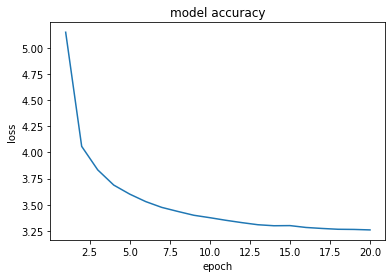

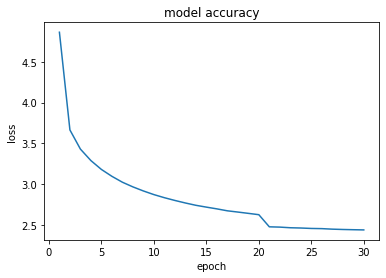

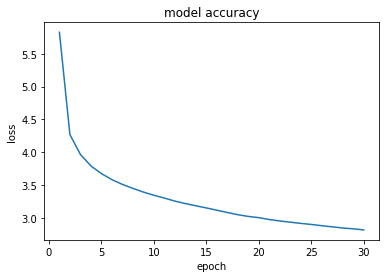

In [ ]:
file = "ImageCap_Data/loss_VGG.txt"
plot_loss(file) 

file = "ImageCap_Data/loss.txt"
plot_loss(file)

file = "ImageCap_Data/loss_2lstm.txt"
plot_loss(file)
